# Predicting Cognitive Decline using Neuroimaging Biomarkers in Healthy Older Adults from the Knight ADRC

## Introduction

Accumulation of ß-amyloid (Aß)plaques, tau-containing neurofibrillary tangles, and progressive neuronal atrophy are the hallmark neuroanatomical biomarkers of Alzheimer Disease (AD), and these progressive changes emerge up to two decades prior to decline in cognition. Following the Aß, tau, and neurodegenerative (ATN) framework, we will investigate the relationship between AD biomarkers and cognitive decline in healthy older adults from the Charles F. and Joanne Knight Alzheimer Disease Research Center (Knight ADRC).

Participants selected for this study were cognitively unimpaired at time of study enrollment and were required to have completed one PiB-positron emission tomography (PET) and magnetic resonance (MR) imaging session, and two cognitive visits. Participants were further separated into those that remained cognitively stable and those that showed cognitive decline.  

The purpose of this project is to determine whether or not biological markers of AD are predictive of cognitive decline. 

## The Data Analysis Pipeline 

### 1. Data: OASIS and ADNI
Data were provided by the Open Access Series of Imaging Studies (OASIS) and the Alzheimer Disease Neuroimaging Initiative (ADNI). Cleaning, merging, and preprocessing were completed using RStudio v1.3.1093. R-files can be found at https://github.com/dianahobbs/DS-SupervisedLearning.

These datasets includes metrics for age, sex, education, race, APOE ε4 status, PET- (amyloid measured in centiloid values) and MR-Imaging (brain volume and thickness), and cognition in older adults that are cognitively unimpaired at baseline. Using this data, I will build a model that will learn from this data to predict individuals that present cognitive decline based on different biomarkers for AD.

#### Import Libraries and Download the Data

In [337]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Graph within notebook
%matplotlib inline 

# Set up matplotlib
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set a random seed
np.random.seed(42)

# Load the data
df = pd.read_csv(r'./Data/data_for_python.csv')

### 2. Data Exploration 
At this stage of the process, it is beneficial to visually explore the data to get a general idea of correlations and patterns. 

#### Preliminary Look at the Data

In [338]:
# What are the column headings 
print("df.keys():\n", df.keys())
df.head()

df.keys():
 Index(['ID', 'AGE', 'SEX', 'EDUC', 'RACE', 'BMI', 'APOE4', 'percenthipp',
       'thick', 'centiloid', 'Cog_Convert', 'followuptime', 'biomarker_group'],
      dtype='object')


,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
0,21,79.562543,Female,18,non-White,31.455775,0,0.561073,2.993750,22.518400,0,0.989747,2
1,23,79.866029,Male,14,non-White,27.799961,0,0.502151,2.779375,26.394551,0,0.992481,1
2,89,71.756664,Male,20,White,27.028939,0,0.494580,3.247375,4.111063,0,0.270677,4
3,257,85.850991,Female,6,White,21.494759,1,0.366224,2.585375,100.092846,0,0.133971,1
4,295,89.878332,Male,18,White,23.334203,1,0.402439,2.840750,86.823717,0,0.948735,2


In [339]:
df.tail()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
455,31119,53.0,Male,16,White,26.757785,0,0.497850,3.129500,2.246167,0,4.084815,4
456,31125,71.0,Female,12,White,21.786092,0,0.533930,2.906375,-1.441793,0,8.462380,4
457,31158,67.0,Male,13,non-White,27.472922,0,0.576317,2.768625,1.687385,0,6.787962,3
458,31165,57.0,Male,12,White,26.283134,1,0.538159,2.947125,-8.258930,0,3.069767,4
459,31168,65.0,Male,16,White,24.952160,1,0.492719,2.947500,94.668663,0,6.911081,2


In [340]:
# Check missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               460 non-null    int64  
 1   AGE              460 non-null    float64
 2   SEX              460 non-null    object 
 3   EDUC             460 non-null    int64  
 4   RACE             460 non-null    object 
 5   BMI              459 non-null    float64
 6   APOE4            460 non-null    int64  
 7   percenthipp      460 non-null    float64
 8   thick            460 non-null    float64
 9   centiloid        460 non-null    float64
 10  Cog_Convert      460 non-null    int64  
 11  followuptime     459 non-null    float64
 12  biomarker_group  460 non-null    int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 46.8+ KB


##### The dataset shows the following information: 
- There are 460 observations, which is very small for machine learning standards.
- Attributes `SEX` and `RACE` are coded as categorical objects; these will need to be recoded as numerical.
- There is one instance missing in both attributes `BMI` and `followuptime`. This will need to be addressed later.   

##### Descriptive Statistics 

In [341]:
df.describe()

,ID,AGE,EDUC,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
count,460.000000,460.000000,460.000000,459.000000,460.000000,460.000000,460.000000,460.000000,460.000000,459.000000,460.000000
mean,14885.565217,70.287426,16.391304,27.747161,0.308696,0.520465,2.921242,21.122330,0.130435,2.675264,3.156522
std,12851.055096,8.534873,2.575046,5.119983,0.462458,0.066774,0.156484,34.435242,0.337148,3.224215,1.029764
min,21.000000,43.000000,6.000000,18.469349,0.000000,0.366224,2.364375,-54.322183,0.000000,-0.951470,1.000000
25%,4407.750000,66.000000,15.000000,24.440171,0.000000,0.475588,2.822594,-1.357975,0.000000,0.530417,2.000000
50%,5202.500000,70.755981,16.000000,26.679264,0.000000,0.516369,2.924625,7.967646,0.000000,0.863978,4.000000
75%,30440.750000,75.755297,18.000000,30.351607,1.000000,0.565604,3.026031,31.573660,0.000000,4.528044,4.000000
max,31168.000000,93.894737,20.000000,57.742001,1.000000,0.833345,3.418625,158.034123,1.000000,12.642955,4.000000


By comparing the 75% percentile to the max, we see that the attribute `centiloid` potentially contains outliers. It may be beneficial to transform our data so our machine learning algorithm may more easily detect patterns. 

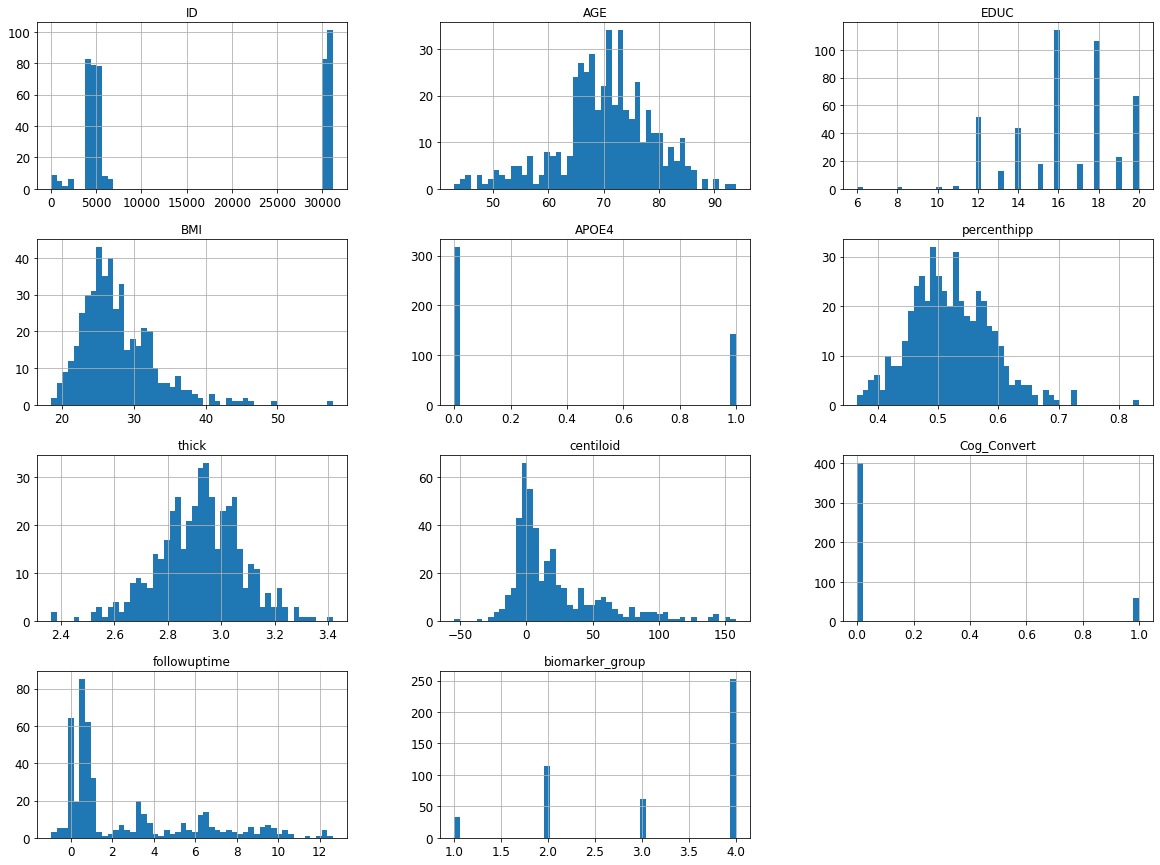

In [342]:
# Histogram 
df.hist(bins=50, figsize=(20,15));

##### The histograms show the following information: 
- The attribute `centiloid` is negatively skewed, which explains why our descriptive statistics were indicating the possibility of outliers. This does make sense conceptually as greater centiloid values are indiciative of greater Aß plaque deposition, and our participants were required to be cognitively unimpaired at baseline. 
- The attribute `followuptime`, which measures the amount of time that passed between baseline cognitive assessment and secondary assessment in years, is additionally negatively skewed. It may be beneficial to restrict the followup time to a shorter amount.
- The attributes `AGE` and `EDUC` are positively skewed. This makes sense as an older population is more likely to have greater levels of education. 
- Finally, the scales of this data are not consistent with one another so we will do a transformation analysis later on. 

### 3. Data Wrangling
In cleaning and preparing our data for analysis, we need to do the following: 
1) Recode categorical variables `SEX` and `RACE` as numerical. 
2) Address the missing values in attributes `BMI` and `followuptime`. 
3) Consider restricting the attribute `followuptime` to 6.5 years. 
4) Transform the data to be on the same scale. 
5) See if some features can be combined in some way.

##### Recode Variables with Text as Numeric

In [343]:
# How are sex and race coded in the data? 
print(f'Sex is coded as: \n{df["SEX"].value_counts()} \n')
print(f'Race is coded as: \n{df["RACE"].value_counts()} \n')

Sex is coded as: 
Female    256
Male      204
Name: SEX, dtype: int64 

Race is coded as: 
White        409
non-White     51
Name: RACE, dtype: int64 



In [344]:
# Recode sex and race as numberical
df["SEX"]=df["SEX"].replace(("Male","Female"),(0,1)) # Males: 0, Females: 1
df["RACE"]=df["RACE"].replace(("White","non-White"),(0,1)) # White: 0, non-White: 1
df.head()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
0,21,79.562543,1,18,1,31.455775,0,0.561073,2.993750,22.518400,0,0.989747,2
1,23,79.866029,0,14,1,27.799961,0,0.502151,2.779375,26.394551,0,0.992481,1
2,89,71.756664,0,20,0,27.028939,0,0.494580,3.247375,4.111063,0,0.270677,4
3,257,85.850991,1,6,0,21.494759,1,0.366224,2.585375,100.092846,0,0.133971,1
4,295,89.878332,0,18,0,23.334203,1,0.402439,2.840750,86.823717,0,0.948735,2


##### Address Missing Values 
We are going to use the median to fill in the missing `BMI` data. 

We are going to completely remove the `followuptime` attribute and 

In [345]:
# Set incomplete rows as a variable to visualize
missingdata = df[df.isnull().any(axis=1)].head()
missingdata

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
145,4560,70.930964,1,20,0,NaN,0,0.490153,2.976750,-0.573740,0,0.844839,4
249,5266,71.062201,0,16,0,24.480891,0,0.545694,3.050875,8.508397,1,NaN,4


In [346]:
# Input median for missing BMI data
medianBMI=df["BMI"].median()
df["BMI"].fillna(medianBMI, inplace=True)
df

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,followuptime,biomarker_group
0,21,79.562543,1,18,1,31.455775,0,0.561073,2.993750,22.518400,0,0.989747,2
1,23,79.866029,0,14,1,27.799961,0,0.502151,2.779375,26.394551,0,0.992481,1
2,89,71.756664,0,20,0,27.028939,0,0.494580,3.247375,4.111063,0,0.270677,4
3,257,85.850991,1,6,0,21.494759,1,0.366224,2.585375,100.092846,0,0.133971,1
4,295,89.878332,0,18,0,23.334203,1,0.402439,2.840750,86.823717,0,0.948735,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,31119,53.000000,0,16,0,26.757785,0,0.497850,3.129500,2.246167,0,4.084815,4
456,31125,71.000000,1,12,0,21.786092,0,0.533930,2.906375,-1.441793,0,8.462380,4
457,31158,67.000000,0,13,1,27.472922,0,0.576317,2.768625,1.687385,0,6.787962,3
458,31165,57.000000,0,12,0,26.283134,1,0.538159,2.947125,-8.258930,0,3.069767,4


In [351]:
# Determine if we want to restrict followup time
print(f'The number of cognitive converters is: \n{df["Cog_Convert"].value_counts()} \n')
print(f'The counts for biomarker group status is: \n{df["biomarker_group"].value_counts()} \n')
followup_subset=df[(df["followuptime"]<6.5)]
print(f'The number of cognitive converters is: \n{followup_subset["Cog_Convert"].value_counts()} \n')
print(f'The counts for biomarker group status is: \n{followup_subset["biomarker_group"].value_counts()} \n')

The number of cognitive converters is: 
0    400
1     60
Name: Cog_Convert, dtype: int64 

The counts for biomarker group status is: 
4    252
2    114
3     61
1     33
Name: biomarker_group, dtype: int64 

The number of cognitive converters is: 
0    330
1     59
Name: Cog_Convert, dtype: int64 

The counts for biomarker group status is: 
4    209
2    108
3     42
1     30
Name: biomarker_group, dtype: int64 



By reducing `followuptime` to less than 6.5 years, we only lost 79 participants, only one individual that showed cognitive decline. This would have a more drastic implication if the majority of cognitive decliners had more distant follow-up visits. However, there is a positive correlation of age and Aß burden, which could pollute the potential predictive ability of biomarkers of AD. 

In [56]:
# Remove followup time variable - restrict followup time to 6.5???





bank_subset1=bank_data[(bank_data['age']>40) &  (bank_data['loan']=="no")]
bank_subset1.head(5)


df=df.drop("followuptime",axis=1)
df

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
0,21,79.562543,1,18,1,31.455775,0,0.561073,2.993750,22.518400,0,2
1,23,79.866029,0,14,1,27.799961,0,0.502151,2.779375,26.394551,0,1
2,89,71.756664,0,20,0,27.028939,0,0.494580,3.247375,4.111063,0,4
3,257,85.850991,1,6,0,21.494759,1,0.366224,2.585375,100.092846,0,1
4,295,89.878332,0,18,0,23.334203,1,0.402439,2.840750,86.823717,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
455,31119,53.000000,0,16,0,26.757785,0,0.497850,3.129500,2.246167,0,4
456,31125,71.000000,1,12,0,21.786092,0,0.533930,2.906375,-1.441793,0,4
457,31158,67.000000,0,13,1,27.472922,0,0.576317,2.768625,1.687385,0,3
458,31165,57.000000,0,12,0,26.283134,1,0.538159,2.947125,-8.258930,0,4


In [335]:
#sns.pairplot(df, hue="Cog_Convert", height=1.5);


# YOU SHOULD LOG TRANSFORM SKEWED DATA NOW AND DEAL WITH MISSING VALUES 

##### Log Transform Variables

In [58]:
#df["centiloid"]=np.log(df["centiloid"])
#df

##### Create a Training and a Test Set

This data is a combination of two different datasets; therefore, we are first going to shuffle the dataset. 

Then we will split the data into a training and a test set using the stratified sampling method. We decided to do this because our dataset is small for machine learning standards, and our data is highly imbalanced, especially in regard to our outcome variable: cognitive conversion. 


In [59]:
# Shuffle the rows in the dataset 
df=df.sample(frac = 1)
df

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group
124,4464,76.399180,0,16,0,27.054553,1,0.583061,3.107875,24.203480,0,2
30,4043,82.012303,0,20,0,27.892607,0,0.503502,3.008125,-19.596914,0,4
199,5127,76.246070,1,19,0,36.946556,1,0.552518,2.780000,114.403171,0,1
439,31020,64.000000,0,16,0,25.223380,0,0.547683,2.966750,7.833984,0,4
154,4587,66.291183,1,16,0,31.134464,1,0.610230,2.876375,70.380749,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
106,4384,62.299385,0,18,1,22.877834,0,0.622744,2.963125,0.945403,0,4
270,6288,72.568694,0,19,0,21.667590,1,0.541959,3.019125,138.965374,0,2
348,30473,70.000000,0,16,0,27.799961,1,0.490235,2.952625,59.688927,0,2
435,30997,59.000000,1,18,0,22.668163,0,0.604909,3.016875,-1.665305,0,4


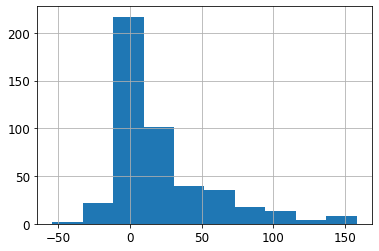

In [60]:
df["centiloid"].hist();

In [65]:
df["centiloid_cat"]=pd.cut(df["centiloid"],
                          bins=[-60., 0, 50., 100., 160., np.inf],
                          labels=[1,2,3,4,5])

# FIX THE CATEGORICAL CENTILOID - WHY AREN'T FIVE CATEGORIES SHOWING????

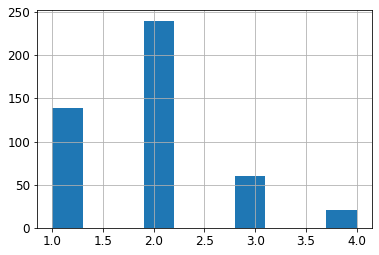

In [66]:
df["centiloid_cat"].hist();

In [67]:
# Split the training and test set such that both contain the same percentages 
from sklearn.model_selection import StratifiedShuffleSplit

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in shuffle_split.split(df, df["centiloid_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [68]:
strat_train_set.head()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group,centiloid_cat
141,4545,67.551606,1,19,0,20.671865,0,0.496835,3.019625,21.380211,1,4,2
408,30808,82.000000,1,18,0,21.871111,0,0.465524,3.015375,14.539364,0,4,2
41,4097,70.742310,1,16,0,38.552572,0,0.616334,3.045000,10.355909,0,4,2
389,30722,66.000000,1,18,0,21.963550,1,0.551870,2.981375,-2.224087,0,4,1
174,4785,66.755981,1,13,0,30.070262,0,0.464996,2.986125,-1.323963,1,4,1


In [69]:
# Display the percentages for centiloid categories 
display(strat_test_set["centiloid_cat"].value_counts() / len(strat_test_set))

2    0.489130
1    0.326087
3    0.163043
4    0.021739
5    0.000000
Name: centiloid_cat, dtype: float64

##### Prepare the Data for Analysis 
Make a copy of the dataset, and then create a test and training set. We are going to 

In [70]:
df1=strat_train_set.copy()

In [71]:
df1.head()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,Cog_Convert,biomarker_group,centiloid_cat
141,4545,67.551606,1,19,0,20.671865,0,0.496835,3.019625,21.380211,1,4,2
408,30808,82.000000,1,18,0,21.871111,0,0.465524,3.015375,14.539364,0,4,2
41,4097,70.742310,1,16,0,38.552572,0,0.616334,3.045000,10.355909,0,4,2
389,30722,66.000000,1,18,0,21.963550,1,0.551870,2.981375,-2.224087,0,4,1
174,4785,66.755981,1,13,0,30.070262,0,0.464996,2.986125,-1.323963,1,4,1


##### Explore the Training Dataset Copy
Since our outcome variable is categorical, we'll be visualizing our data using barplots. 


###### Correlations
Explore how much each attribute correlates with the median house value. 

In [241]:
corr_matrix = df1.corr()
corr_matrix["Cog_Convert"].sort_values(ascending=False)

Cog_Convert        1.000000
EDUC               0.168245
AGE                0.154504
centiloid          0.137017
APOE4              0.072782
thick              0.015061
BMI               -0.025317
SEX               -0.026753
RACE              -0.053954
percenthipp       -0.111937
biomarker_group   -0.122516
ID                -0.268896
Name: Cog_Convert, dtype: float64

In [205]:
import seaborn as sn
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

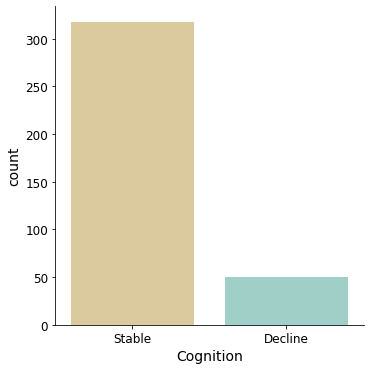

In [167]:
# Counts for cognitive converters vs non-converters 
fig1=sns.catplot(x="Cog_Convert", kind="count", palette="BrBG",data=df1)
fig1.set(xlabel="Cognition")
fig1.set_xticklabels(["Stable", "Decline"])
plt.show()

###### Categorical Variables

# SET THESE IN A GRID LAYOUT 

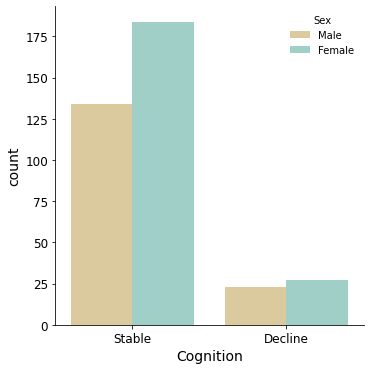

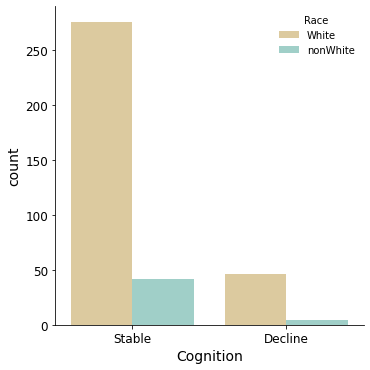

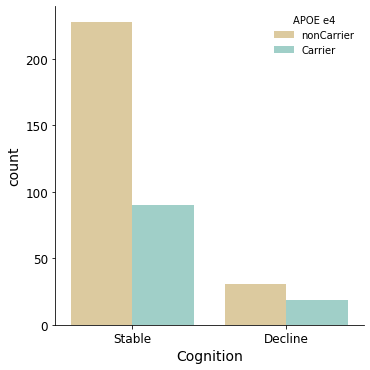

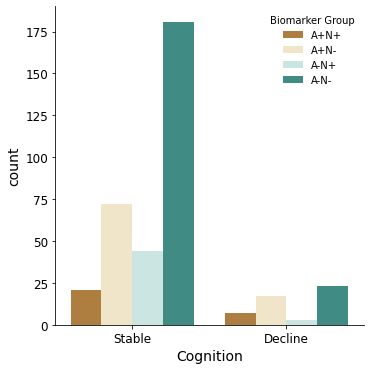

In [237]:
# Converters vs Sex
fig2=sns.catplot(x="Cog_Convert", hue="SEX", legend=False, palette="BrBG", kind="count", data=df1);
fig2.set(xlabel="Cognition")
fig2.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Sex', loc='upper right', labels=['Male', 'Female'], frameon=False)
plt.show(gs[0,0])

# Converters vs Race
fig3=sns.catplot(x="Cog_Convert", hue="RACE", legend=False, palette="BrBG", kind="count", data=df1);
fig3.set(xlabel="Cognition")
fig3.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Race', loc='upper right', labels=['White', 'nonWhite'], frameon=False)
plt.show(gs[:,1])

# Converters vs APOE e4 carriers 
fig4=sns.catplot(x="Cog_Convert", hue="APOE4", legend=False, palette="BrBG", kind="count", data=df1);
fig4.set(xlabel="Cognition")
fig4.set_xticklabels(["Stable", "Decline"])
plt.legend(title='APOE e4', loc='upper right', labels=['nonCarrier', 'Carrier'], frameon=False)
plt.show()

# Converters vs biomarker group 
fig5=sns.catplot(x="Cog_Convert", hue="biomarker_group", legend=False, palette="BrBG", kind="count", data=df1);
fig5.set(xlabel="Cognition")
fig5.set_xticklabels(["Stable", "Decline"])
plt.legend(title='Biomarker Group', loc='upper right', labels=['A+N+', 'A+N-','A-N+', 'A-N-'], frameon=False)
plt.show()

###### Continuous Variables

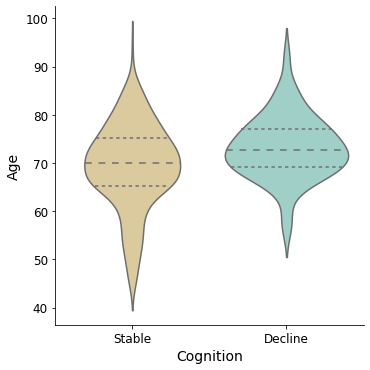

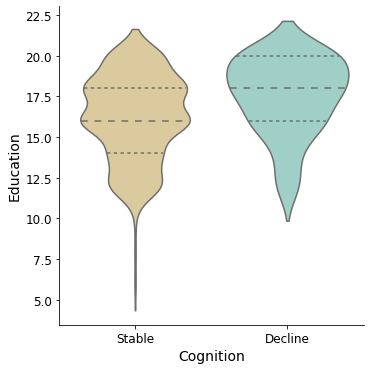

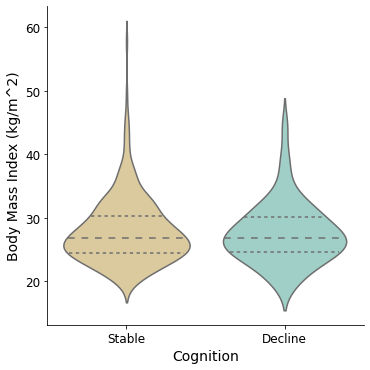

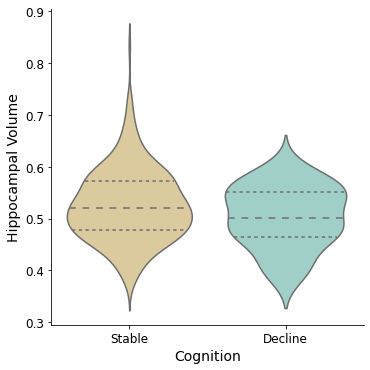

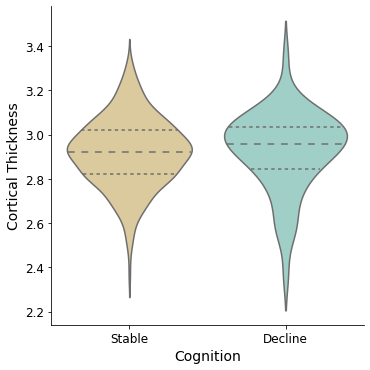

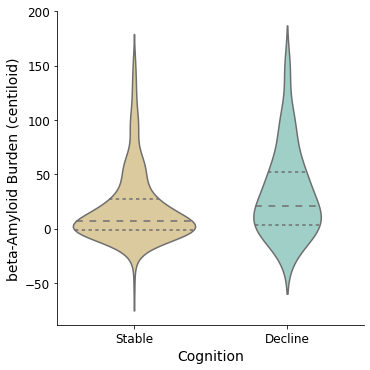

In [204]:
# Converters and Age
fig6=sns.catplot(x="Cog_Convert", y="AGE", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig6.set(xlabel="Cognition", ylabel="Age")
fig6.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Education 
fig7=sns.catplot(x="Cog_Convert", y="EDUC", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig7.set(xlabel="Cognition", ylabel="Education")
fig7.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and BMI 
fig8=sns.catplot(x="Cog_Convert", y="BMI", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig8.set(xlabel="Cognition", ylabel="Body Mass Index (kg/m^2)")
fig8.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Hippocampal Volume  
fig9=sns.catplot(x="Cog_Convert", y="percenthipp", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig9.set(xlabel="Cognition", ylabel="Hippocampal Volume")
fig9.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Cortical thickness 
fig10=sns.catplot(x="Cog_Convert", y="thick", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig10.set(xlabel="Cognition", ylabel="Cortical Thickness")
fig10.set_xticklabels(["Stable", "Decline"])
plt.show()

# Converters and Centiloid
fig10=sns.catplot(x="Cog_Convert", y="centiloid", legend=False, palette="BrBG", kind="violin", inner="quartile",data=df1);
fig10.set(xlabel="Cognition", ylabel="beta-Amyloid Burden (centiloid)")
fig10.set_xticklabels(["Stable", "Decline"])
plt.show()

Age and centiloid had effects - so explore what that looks like 

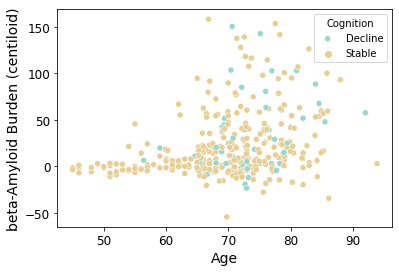

In [240]:
fig11=sns.scatterplot(x="AGE", y="centiloid", hue="Cog_Convert", palette="BrBG", data=df1)
fig11.set(xlabel="Age", ylabel="beta-Amyloid Burden (centiloid)")
fig11.legend(title="Cognition", labels=["Decline", "Stable"]);


You see greater centiloid levels, indicating beta-amyloid accumulation, as individuals age. 

##### Feature Engineering: Experimenting with Attribute Combinations 

Which features are highly related? They may make more sense to be combined. 

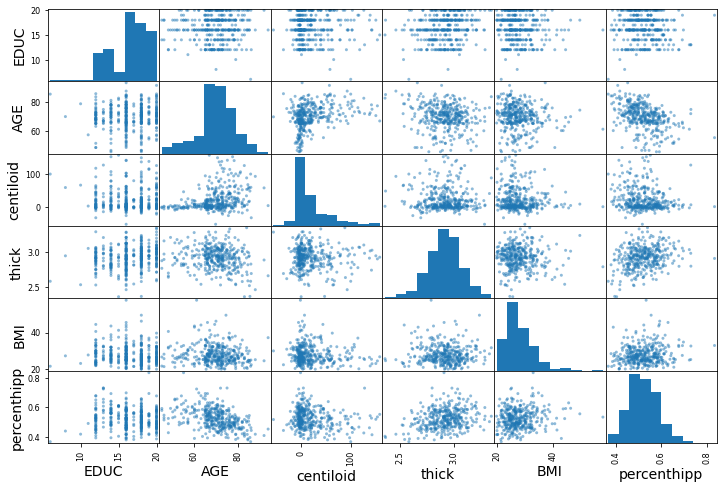

In [250]:
from pandas.plotting import scatter_matrix
attributes = ["EDUC", "AGE", "centiloid", "thick", "BMI", "percenthipp"]
scatter_matrix(df1[attributes], figsize=(12, 8));

Hippocampal volume and cortical thickness are positively related and may make sense to be combined. So are Age and Centiloid. 

In [263]:
df1["cent_x_age"]=df1["centiloid"]/df1["AGE"]
df1["educ_x_age"]=df1["EDUC"]/df1["AGE"]
df1["vol_x_thick"]=df1["percenthipp"]/df1["thick"]
df1["cent_x_BMI"]=df1["centiloid"]/df1["BMI"]
df1["cent_x_hipp"]=df1["centiloid"]/df1["percenthipp"]
df1["age_x_BMI"]=df1["AGE"]/df1["BMI"]
df1["cent_x_thick"]=df1["centiloid"]/df1["thick"]
df1["cent_x_hipp*thick"]=df1["centiloid"]/(df1["percenthipp"]*df1["thick"])


In [264]:
corr_matrix = df1.corr()
corr_matrix["Cog_Convert"].sort_values(ascending=False)

Cog_Convert          1.000000
EDUC                 0.168245
AGE                  0.154504
cent_x_hipp*thick    0.152905
cent_x_hipp          0.151293
cent_x_thick         0.138336
centiloid            0.137017
cent_x_BMI           0.131832
cent_x_age           0.130103
age_x_BMI            0.106308
APOE4                0.072782
educ_x_age           0.015316
thick                0.015061
BMI                 -0.025317
SEX                 -0.026753
RACE                -0.053954
percenthipp         -0.111937
biomarker_group     -0.122516
vol_x_thick         -0.123312
ID                  -0.268896
Name: Cog_Convert, dtype: float64

##### Separate Predictors and Target Variables 

In [266]:
df1 = strat_train_set.drop("Cog_Convert", axis=1) # drop labels for training set
df1_labels = strat_train_set["Cog_Convert"].copy() #which is our target 

In [267]:
df1.head()

,ID,AGE,SEX,EDUC,RACE,BMI,APOE4,percenthipp,thick,centiloid,biomarker_group,centiloid_cat
141,4545,67.551606,1,19,0,20.671865,0,0.496835,3.019625,21.380211,4,2
408,30808,82.000000,1,18,0,21.871111,0,0.465524,3.015375,14.539364,4,2
41,4097,70.742310,1,16,0,38.552572,0,0.616334,3.045000,10.355909,4,2
389,30722,66.000000,1,18,0,21.963550,1,0.551870,2.981375,-2.224087,4,1
174,4785,66.755981,1,13,0,30.070262,0,0.464996,2.986125,-1.323963,4,1


In [268]:
df1_labels

141    1
408    0
41     0
389    0
174    1
      ..
172    0
288    0
452    0
315    0
271    0
Name: Cog_Convert, Length: 368, dtype: int64

##### Data Wrangling
Make sure categorical variables are encoded as labels and not numbers. 

In [ ]:
SEX, RACE, APOE, BIOMARKER 

In [269]:
sex = df1["SEX"]
race = df1["RACE"]
apoe = df1["APOE4"]
biogroup = df1["biomarker_group"]


In [272]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
sex_encoded = ordinal_encoder.fit_transform(sex)
print('cats = ', ordinal_encoder.categories_)
sex_encoded[:1]

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1
 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1
 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1
 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0
 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1
 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [273]:
from sklearn.preprocessing import OneHotEncoder

sex_encoder = OneHotEncoder()
sex_1hot = sex_encoder.fit_transform(sex)
print('cats = ', sex_encoder.categories_)
sex_1hot

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1
 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1
 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1
 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0
 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1
 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

##### Transformation Pipelines

In [277]:
#set up entire workflow as a pipeline ******* 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df1_num = df1.drop(["SEX","RACE","APOE4","biomarker_group"], axis=1)


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),  # centers and scales the data
])

df1_num_tr = num_pipeline.fit_transform(df1_num)
df1_num_tr

array([[-8.27637605e-01, -2.66405379e-01,  1.00117448e+00, ...,
         6.19091430e-01,  5.05071014e-04,  8.97277522e-02],
       [ 1.21515870e+00,  1.40760004e+00,  6.16589711e-01, ...,
         5.92341265e-01, -1.96573775e-01,  8.97277522e-02],
       [-8.62484071e-01,  1.03272798e-01, -1.52579827e-01, ...,
         7.78805649e-01, -3.17095498e-01,  8.97277522e-02],
       ...,
       [ 1.23810448e+00, -1.72064710e+00, -1.52579827e-01, ...,
        -6.91666645e-01, -6.82733826e-01, -1.18026505e+00],
       [ 1.16872267e+00, -2.76339614e+00,  6.16589711e-01, ...,
         1.51758226e+00, -5.82926133e-01,  8.97277522e-02],
       [-6.90585209e-01,  7.35241916e-01, -1.52579827e-01, ...,
         1.32639726e+00,  5.26528910e-01,  8.97277522e-02]])

In [278]:
# full pipeline for numerical and categorical
from sklearn.compose import ColumnTransformer

num_attribs = list(df1_num)
cat_attribs = ["SEX","RACE","APOE4","biomarker_group"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

df1_prepared = full_pipeline.fit_transform(df1)

In [279]:
df1_prepared

array([[-0.82763761, -0.26640538,  1.00117448, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.2151587 ,  1.40760004,  0.61658971, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86248407,  0.1032728 , -0.15257983, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.23810448, -1.7206471 , -0.15257983, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.16872267, -2.76339614,  0.61658971, ...,  0.        ,
         0.        ,  1.        ],
       [-0.69058521,  0.73524192, -0.15257983, ...,  1.        ,
         0.        ,  0.        ]])

#### 4. Data Analysis 
- analyze the data: Choose the model you use for the question at hand

YOU ARE NOW READY TO SELECT A MACHINE LEARNING MODEL 

##### Training and Evaluating on the Training Set 


# Algorithms 
## k-Nearest Neighbor Classification 
2. Import the estimator class (linear reg, decision tree, etc)
3. Instantiate the estimator class with hyperparameters (call it into existence and set to variable)
4. Fit the model to the training data
5. Apply the model to new data (test data)
6. Evaluate the model

In [280]:
# import the estimator class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the estimator class with hyperparameters
clf = KNeighborsClassifier(n_neighbors=3)

# it the model to the training data
clf.fit(X_train, y_train)

# apply the model to new data (test data)
print("Test set predictions:", clf.predict(X_test))

# evaluate the model
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))

NameError: name 'X_train' is not defined


#### 5. Data Finetuning 
- fine tune the model: after your first attempt to analyzing the data, are there any improvements you can make? better tuning parameters? ensemble methods? 

#### 6. Data Conclusions 
- conclusions 

how did it do on the test set?? 

## Code
not line by line, but give a high-level overview of how the code works. Describe any particularly tricky parts. 

## Project Takeaways 
conclusions, what did you learn? 

# Make a separate file that just has the code alone
